## Comparison between cones in dendritic field and contacted cones <br/>& coverage factor of BC types

In [1]:
import numpy as np
from scipy.stats import itemfreq
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.ndimage import morphology
%matplotlib inline
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rcParams.update({'mathtext.default': 'regular'})
matplotlib.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

In [2]:
skeleton_data=loadmat('data/skeletons_OPL_final.mat')
skeleton_ids=skeleton_data['kn_allSkeletons_e2006_IDs'].flatten()
skeletons=skeleton_data['kn_allSkeletons_e2006'].flatten()
M=np.loadtxt('data/coordinate_rotation')

In [3]:
BC_ids=np.loadtxt('data/BC_IDs_new')
cut_off_cones=np.array([73,72,71,74,201,202,211,203,88,204,142,34,4,30,199])+2000
BC_excluded=np.array([691,709,827,836])
blue_cones=np.array([2006,2007,2009,2024,2028,2029])
cones_outside_cbc9=np.array([193,209,200,198,197,199,73,72,71,74,69,67,66,211,86,88,87,120,85,204,84,207,128,114,126,127,125,142,130,104,106,175,135])+2000

cell_ids=[]
for i in range(BC_ids.shape[0]):
    if BC_ids[i,4] in range(58,72):
        cell_ids.append([BC_ids[i,0],BC_ids[i,1],BC_ids[i,4]])
for i in skeleton_ids:
    if (i >2000)&(i<3000):
        if i in blue_cones:
            cell_ids.append([i,i,81])
        elif i in cones_outside_cbc9:
            cell_ids.append([i,i,82])
        elif i in cut_off_cones:
            cell_ids.append([i,i,83])
        else:
            cell_ids.append([i,i,80])
    elif (i>3000):
        cell_ids.append([i,i,84])
cell_ids=np.array(cell_ids).astype(int)
cone_ids=cell_ids[(cell_ids[:,2]>=80)&(cell_ids[:,2]<84)]
green_cones=cone_ids[(np.in1d(cone_ids[:,0],blue_cones,invert=True))&(np.in1d(cone_ids[:,0],cones_outside_cbc9,invert=True)),0]

In [4]:
cone_projections=[]
for i in range(cell_ids.shape[0]):
    if (cell_ids[i,2]>=80)&(cell_ids[i,2]<84):
        data=np.loadtxt('data/cone_projections/cell'+str(cell_ids[i,0]).zfill(4)+'_rot_x_complete.gz')
        cone_projections.append(data)

In [5]:
soma_data=loadmat('data/soma_positions.mat')
soma_pos=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_allSomata']
soma_internal_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs']
soma_line_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs_pure_forSomata']
soma_pos[:,:3]=np.dot(M,soma_pos[:,:3].T).T
soma_pos[:,:3]=soma_pos[:,:3]

### Coverage factor using cones and morphological closing

In [6]:
#define structure with diameter 0.75µm (=15px a 50nm)
struct=np.zeros((31,31))
for i in range(31):
    for j in range(31):
        if (i-15)**2+(j-15)**2<=225:
            struct[i,j]=1

In [7]:
cone_projections_reduced=[]
for i in range(cone_ids.shape[0]):
    data=(cone_projections[i]/np.array([3,2])).astype(int)#still have to scale it correctly
    data_min=np.min(data,axis=0)
    data=data-data_min
    data_max=np.max(data,axis=0)
    data_im=np.zeros(data_max+1)
    data_im[tuple(data.astype(int).T)]=1
    data_im=morphology.grey_opening(data_im,footprint=struct)
    data2=np.array(np.where(data_im==1)).T+data_min
    cone_projections_reduced.append(data2)#*np.array([3,2]))

In [8]:
BC_data=cell_ids[cell_ids[:,2]<80]
BC_data[:,1]=BC_data[:,2]
BC_data[:,2]=0
BC_data_green=np.copy(BC_data)
BC_data_blue=np.copy(BC_data)
BC_type_contacts=[[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
BC_type_contacts_green=[[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
BC_type_contacts_blue=[[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(BC_data.shape[0]):
    cell=BC_data[i,0]
    type_ind=BC_data[i,1]-58
    nodes_complete=np.empty((0,3))
    for skel in np.where(skeleton_ids==cell)[0]:
        nodes=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('nodes')][:,:3]
        edges=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('edges')]
        nodes=nodes[np.unique(edges)-1,:]
        nodes=nodes[:,:3]/[16.5,16.5,25]
        nodes=np.dot(M,nodes.T).T
        nodes_complete=np.concatenate((nodes_complete,nodes[nodes[:,0]<soma_pos[soma_line_ids[0,np.where(soma_internal_ids==cell_ids[i,1])[1][0]]-1,0],0:3]),axis=0)
    nodes_proj=np.ascontiguousarray((nodes_complete[:,1:]/np.array([3,2])).astype(int))
    for cone in range(len(cone_projections_reduced)):
        if np.sum(np.in1d(nodes_proj.view(dtype='int64,int64').reshape(nodes_proj.shape[0]),\
                      np.ascontiguousarray(cone_projections_reduced[cone]).view(dtype='int64,int64').reshape(cone_projections_reduced[cone].shape[0])))>0:
            if not cone_ids[cone,0] in cut_off_cones:
                BC_data[i,2]+=1
                BC_type_contacts[type_ind]+=[cone_ids[cone,0].astype(int)]
            if cone_ids[cone,0] in green_cones:
                BC_data_green[i,2]+=1
                BC_type_contacts_green[type_ind]+=[cone_ids[cone,0].astype(int)]
            elif cone_ids[cone,0] in blue_cones:
                BC_data_blue[i,2]+=1
                BC_type_contacts_blue[type_ind]+=[cone_ids[cone,0].astype(int)]

In [9]:
cones_in_reach3=pd.DataFrame(BC_data,columns=['cell','type','count'])
cones_in_reach3=cones_in_reach3[np.in1d(cones_in_reach3['cell'],BC_excluded,invert=True)].reset_index().drop('index',axis=1)
cones_in_reach_green3=pd.DataFrame(BC_data_green,columns=['cell','type','count'])
cones_in_reach_green3=cones_in_reach_green3[np.in1d(cones_in_reach_green3['cell'],BC_excluded,invert=True)].reset_index().drop('index',axis=1)
cones_in_reach_blue3=pd.DataFrame(BC_data_blue,columns=['cell','type','count'])
cones_in_reach_blue3=cones_in_reach_blue3[np.in1d(cones_in_reach_blue3['cell'],BC_excluded,invert=True)].reset_index().drop('index',axis=1)
cones_in_type_reach3=np.zeros((14,2))
cones_in_type_reach3[:,0]=np.arange(58,72)
for i in range(len(BC_type_contacts)):
    cones_in_type_reach3[i,1]=len(np.unique(BC_type_contacts[i]))
cones_in_type_reach_green3=np.zeros((14,2))
cones_in_type_reach_green3[:,0]=np.arange(58,72)
for i in range(len(BC_type_contacts_green)):
    cones_in_type_reach_green3[i,1]=len(np.unique(BC_type_contacts_green[i]))
cones_in_type_reach_blue3=np.zeros((14,2))
cones_in_type_reach_blue3[:,0]=np.arange(58,72)
for i in range(len(BC_type_contacts_blue)):
    cones_in_type_reach_blue3[i,1]=len(np.unique(BC_type_contacts_blue[i]))

In [10]:
#OPL coverage from cones
for i in range(len(cones_in_type_reach3)):
    print(np.sum(cones_in_reach3[cones_in_reach3['type']==i+58]['count'])/cones_in_type_reach3[i,1])

1.47524752475
1.546875
1.36752136752
1.90163934426
1.85606060606
1.30630630631
1.60317460317
1.95035460993
1.11764705882
1.58064516129
1.65079365079
1.21153846154
1.45192307692
4.37414965986


In [11]:
contact_summary=pd.read_pickle('data/cone_contact_predictions')
true_contacts=contact_summary[(contact_summary['prediction']==1)].reset_index().drop('index',axis=1)
true_contacts_green=contact_summary.ix[(contact_summary['prediction']==1)&(contact_summary['cone_type']=='green'),:4]
true_contacts_blue=contact_summary.ix[(contact_summary['prediction']==1)&(contact_summary['cone_type']=='blue'),:4]

In [12]:
stat_bc_contacts_all=pd.DataFrame(BC_ids[(BC_ids[:,4]>=58)&(BC_ids[:,4]<=71)&np.in1d(BC_ids[:,0],BC_excluded,invert=True)][:,[0,4]],columns=['cell','type'])
all_contact_freq_type=itemfreq(true_contacts['cell'].as_matrix())
for i in range(stat_bc_contacts_all.shape[0]):
    stat_bc_contacts_all.loc[i,'count']=0
    try:
        stat_bc_contacts_all.ix[i,'count']=all_contact_freq_type[all_contact_freq_type[:,0]==stat_bc_contacts_all.ix[i,'cell'],1]
    except ValueError:
        continue

In [13]:
stat_bc_contacts_green=pd.DataFrame(BC_ids[(BC_ids[:,4]>=58)&(BC_ids[:,4]<=71)&np.in1d(BC_ids[:,0],BC_excluded,invert=True)][:,[0,4]],columns=['cell','type'])
stat_bc_contacts_blue=stat_bc_contacts_green.copy()
green_contact_freq_type=itemfreq(true_contacts_green['cell'].as_matrix())
for i in range(stat_bc_contacts_green.shape[0]):
    stat_bc_contacts_green.loc[i,'count']=0
    try:
        stat_bc_contacts_green.ix[i,'count']=green_contact_freq_type[green_contact_freq_type[:,0]==stat_bc_contacts_green.ix[i,'cell'],1]
    except ValueError:
        continue
blue_contact_freq_type=itemfreq(true_contacts_blue['cell'].as_matrix())
for i in range(stat_bc_contacts_blue.shape[0]):
    stat_bc_contacts_blue.loc[i,'count']=0
    try:
        stat_bc_contacts_blue.ix[i,'count']=blue_contact_freq_type[blue_contact_freq_type[:,0]==stat_bc_contacts_blue.ix[i,'cell'],1]
    except ValueError:
        continue

In [14]:
stat_bc_contacts_joined=pd.concat({'contacted': stat_bc_contacts_all, 'in dendritic field': cones_in_reach3})
stat_bc_contacts_joined=stat_bc_contacts_joined.reset_index().drop('level_1',axis=1).rename(columns={'level_0':'count_type'})
stat_bc_contacts_joined_green=pd.concat({'contacted': stat_bc_contacts_green, 'in dendritic field': cones_in_reach_green3})
stat_bc_contacts_joined_green=stat_bc_contacts_joined_green.reset_index().drop('level_1',axis=1).rename(columns={'level_0':'count_type'})
stat_bc_contacts_joined_blue=pd.concat({'contacted': stat_bc_contacts_blue, 'in dendritic field': cones_in_reach_blue3})
stat_bc_contacts_joined_blue=stat_bc_contacts_joined_blue.reset_index().drop('level_1',axis=1).rename(columns={'level_0':'count_type'})

#### Figure 3F

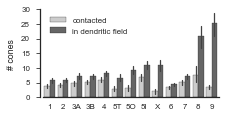

In [15]:
labels = ['1','2','3A','3B','4','5T','5O','5I','X','6','7','8','9']
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 0, "ytick.major.size": 4})
with matplotlib.rc_context({"lines.linewidth": 0.7}):
    plt.figure(figsize=(8/2.54,4/2.54))
    ax=sns.barplot(x='type',y='count',data=stat_bc_contacts_joined,hue='count_type',order=np.arange(58,71),ci=95,palette=[np.array([0.8,0.8,0.8,1.]),np.array([0.4,0.4,0.4,1.])])
    ax.set_xticklabels(labels)
    ax.set(ylabel='# cones',xlabel='',ylim=(0,30))
    ax.spines['left'].set_position(('outward',3))
    legend=plt.legend(loc='upper left')
    sns.despine()
#     plt.savefig('figures/dendritic_field_vs_contacted_cones.svg',bbox_inches='tight',dpi=300)
    plt.show()

In [16]:
contacted_cones_ratio=stat_bc_contacts_all.copy()
for i in range(contacted_cones_ratio.shape[0]):
    contacted_cones_ratio.loc[i,'cones']=cones_in_reach3[cones_in_reach3['cell']==contacted_cones_ratio.ix[i,'cell']]['count'].as_matrix()
for i in range(contacted_cones_ratio.shape[0]):
    contacted_cones_ratio.loc[i,'ratio']=contacted_cones_ratio.ix[i,'count']/contacted_cones_ratio.ix[i,'cones']
    
contacted_cones_ratio_green=stat_bc_contacts_green.copy()
for i in range(contacted_cones_ratio_green.shape[0]):
    contacted_cones_ratio_green.loc[i,'cones']=cones_in_reach_green3[cones_in_reach_green3['cell']==contacted_cones_ratio_green.ix[i,'cell']]['count'].as_matrix()
for i in range(contacted_cones_ratio_green.shape[0]):
    contacted_cones_ratio_green.loc[i,'ratio']=contacted_cones_ratio_green.ix[i,'count']/contacted_cones_ratio_green.ix[i,'cones']
    
contacted_cones_ratio_blue=stat_bc_contacts_blue.copy()
for i in range(contacted_cones_ratio_blue.shape[0]):
    contacted_cones_ratio_blue.loc[i,'cones']=cones_in_reach_blue3[cones_in_reach_blue3['cell']==contacted_cones_ratio_blue.ix[i,'cell']]['count'].as_matrix()
for i in range(contacted_cones_ratio_blue.shape[0]):
    contacted_cones_ratio_blue.loc[i,'ratio']=contacted_cones_ratio_blue.ix[i,'count']/contacted_cones_ratio_blue.ix[i,'cones']

In [17]:
contacted_cones_ratio_joined=pd.concat({'blue': contacted_cones_ratio_blue, 'green': contacted_cones_ratio_green})
contacted_cones_ratio_joined=contacted_cones_ratio_joined.reset_index().drop('level_1',axis=1).rename(columns={'level_0':'cone_type'})

#### Figure 3G

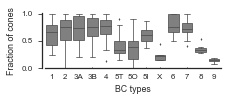

In [18]:
labels = ['1','2','3A','3B','4','5T','5O','5I','X','6','7','8','9']
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 0, "ytick.major.size": 4})
plt.figure(figsize=(8/2.54,2.5/2.54))
ax=sns.boxplot(x='type',y='ratio',data=contacted_cones_ratio,order=np.arange(58,71),color='grey',fliersize=2,linewidth=0.75)
ax.set_xticklabels(labels)
ax.set_yticks([0,0.5,1.0])
ax.set(ylabel='Fraction of cones',ylim=(0,1.01),xlabel='BC types')
ax.spines['left'].set_position(('outward',3))
sns.despine()
# plt.savefig('figures/dendritic_field_vs_contacted_cones_ratio.svg',bbox_inches='tight',dpi=300)
plt.show()